In [1]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
import miceforest as mf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [54]:
# fetch dataset 
communities_and_crime_unnormalized = fetch_ucirepo(id=211) 
# data (as pandas dataframes) 
x = communities_and_crime_unnormalized.data.features 
y = communities_and_crime_unnormalized.data.targets 

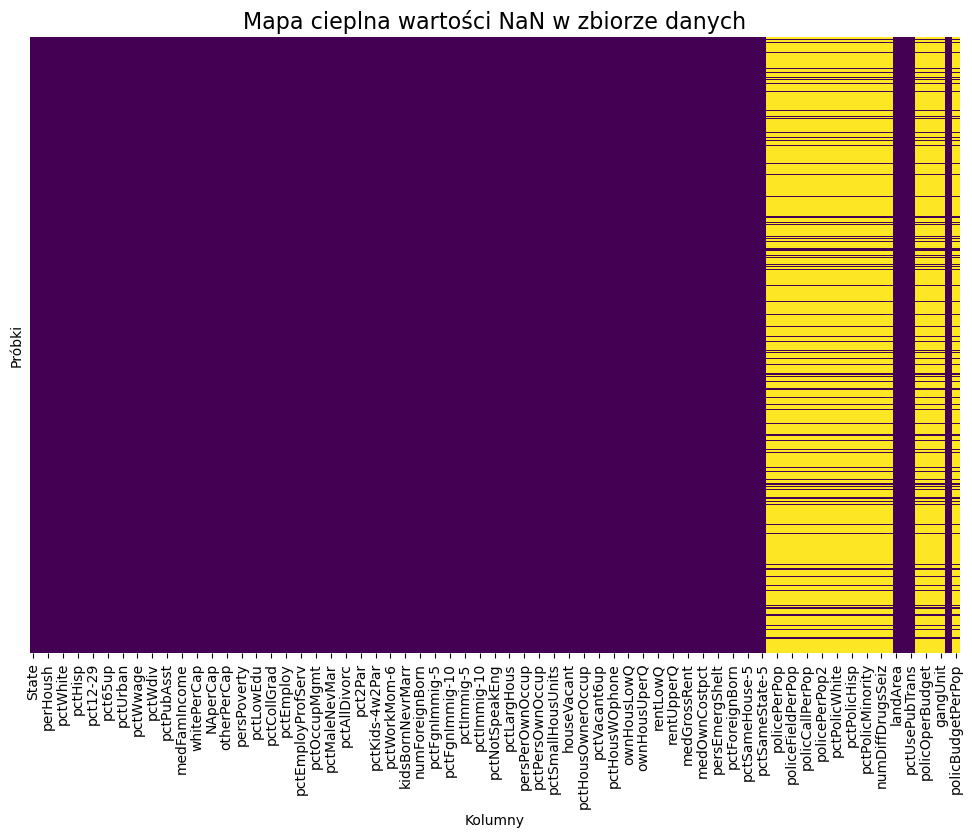

In [37]:
# Tworzenie mapy cieplnej brakujących wartości
plt.figure(figsize=(12, 8))
sns.heatmap(x.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa cieplna wartości NaN w zbiorze danych", fontsize=16)
plt.xlabel("Kolumny")
plt.ylabel("Próbki")
plt.show()

In [55]:
# Połączenie X i y w jeden DataFrame
data = pd.concat([x, y], axis=1)

In [56]:
data.select_dtypes("object").head() # sprawdzam czy występują dane tekstowe lub mieszane

,State
0,NJ
1,PA
2,OR
3,NY
4,MN


In [57]:
data.drop(["State"], axis=1, inplace=True) 

In [58]:
# podsumowanie brakujących wartości
missing_summary = (
    x.isnull().sum()
    .to_frame(name='Missing Values')
    .reset_index()
    .rename(columns={'index': 'Column'})
)
missing_summary

,Column,Missing Values
0,State,0
1,pop,0
2,perHoush,0
3,pctBlack,0
4,pctWhite,0
...,...,...
120,policOperBudget,1872
121,pctPolicPatrol,1872
122,gangUnit,1872
123,pctOfficDrugUnit,0


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 142 entries, pop to nonViolPerPop
dtypes: float64(114), int64(28)
memory usage: 2.4 MB


In [10]:
data.head()

,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,violentPerPop,nonViolPerPop
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [11]:
# podsumowanie brakujących wartości
missing_summary = (
    data.isnull().sum()
    .to_frame(name='Missing Values')
    .reset_index()
    .rename(columns={'index': 'Column'})
)
missing_summary

,Column,Missing Values
0,pop,0
1,perHoush,0
2,pctBlack,0
3,pctWhite,0
4,pctAsian,0
...,...,...
137,autoTheftPerPop,3
138,arsons,91
139,arsonsPerPop,91
140,violentPerPop,221


In [59]:
y=data['pctBlack']
x=data.drop('pctBlack',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)

In [60]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)

In [88]:
# Imputacja braków metodą wypełniania zerami
imp_zero = SimpleImputer(strategy='constant', fill_value=0)
x_train_imputed = imp_zero.fit_transform(x_train)
x_test_imputed = imp_zero.transform(x_test)

In [89]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [90]:
models={'Linear Regression':LinearRegression(),
           'Decision Tree':DecisionTreeRegressor(),
           'Random Forest':RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
            'Gradient Boosting':GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)}

In [91]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse_zero = mean_squared_error(y_test, y_pred)
    mae_zero = mean_absolute_error(y_test, y_pred)
    rmse_zero = np.sqrt(mse_zero)
    r2_zero = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse_zero))
    print("MAE: {:.2f}".format(mae_zero))
    print("RMSE: {:.2f}".format(rmse_zero))
    print("R²: {:.2f}".format(r2_zero))
    print("-" * 30)

Model: Linear Regression
MSE: 6.90
MAE: 1.58
RMSE: 2.63
R²: 0.97
------------------------------
Model: Decision Tree
MSE: 17.69
MAE: 2.32
RMSE: 4.21
R²: 0.91
------------------------------
Model: Random Forest
MSE: 25.13
MAE: 3.08
RMSE: 5.01
R²: 0.88
------------------------------
Model: Gradient Boosting
MSE: 8.71
MAE: 1.67
RMSE: 2.95
R²: 0.96
------------------------------


In [92]:
# Imputacja braków metodą wypełniania medianą
imp_median = SimpleImputer(strategy='median')
x_train_imputed = imp_median.fit_transform(x_train)
x_test_imputed = imp_median.transform(x_test)

In [93]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [94]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse_median = mean_squared_error(y_test, y_pred)
    mae_median = mean_absolute_error(y_test, y_pred)
    rmse_median = np.sqrt(mse_median)
    r2_median = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse_median))
    print("MAE: {:.2f}".format(mae_median))
    print("RMSE: {:.2f}".format(rmse_median))
    print("R²: {:.2f}".format(r2_median))
    print("-" * 30)

Model: Linear Regression
MSE: 6.87
MAE: 1.58
RMSE: 2.62
R²: 0.97
------------------------------
Model: Decision Tree
MSE: 17.97
MAE: 2.34
RMSE: 4.24
R²: 0.91
------------------------------
Model: Random Forest
MSE: 25.13
MAE: 3.08
RMSE: 5.01
R²: 0.88
------------------------------
Model: Gradient Boosting
MSE: 8.68
MAE: 1.66
RMSE: 2.95
R²: 0.96
------------------------------


In [15]:
# Skalowanie danych
scaler = StandardScaler()
# Skalowanie danych treningowych
scaler.fit(aggregated_train)  # Uwaga: skalowanie oparte na imputowanych danych treningowych
x_train_imputed = pd.DataFrame(scaler.transform(aggregated_train), columns=aggregated_train.columns, index=aggregated_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(aggregated_test), columns=aggregated_test.columns, index=aggregated_test.index)

In [85]:
# 2. Ustawienie IterativeImputer dla MICE
def multiple_imputation_mice(train, test, num_imputations=3):
    train_imputed_datasets = []
    test_imputed_datasets = []

    for i in range(num_imputations):
        # IterativeImputer z prostym estymatorem dla MICE
        mice_imputer = IterativeImputer(random_state=i, max_iter=10, sample_posterior=True)

        # Imputacja dla zbioru treningowego
        imputed_train = pd.DataFrame(mice_imputer.fit_transform(train), columns=train.columns)
        train_imputed_datasets.append(imputed_train)

        # Imputacja dla zbioru testowego
        imputed_test = pd.DataFrame(mice_imputer.transform(test), columns=test.columns)
        test_imputed_datasets.append(imputed_test)

    # Agregacja (średnia) wyników imputacji
    aggregated_train = pd.concat(train_imputed_datasets).groupby(level=0).mean()
    aggregated_test = pd.concat(test_imputed_datasets).groupby(level=0).mean()

    return aggregated_train, aggregated_test


# 3. Imputacja wielokrotna za pomocą MICE
aggregated_train, aggregated_test = multiple_imputation_mice(x_train, x_test, num_imputations=3)


In [86]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(aggregated_train)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
aggregated_train_scaled = pd.DataFrame(scaler.transform(aggregated_train), columns=aggregated_train.columns, index=aggregated_train.index)
aggregated_test_scaled = pd.DataFrame(scaler.transform(aggregated_test), columns=aggregated_test.columns, index=aggregated_test.index)

In [95]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(aggregated_train_scaled, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(aggregated_test_scaled)
    
    # obliczanie metryk
    mse_mice = mean_squared_error(y_test, y_pred)
    mae_mice = mean_absolute_error(y_test, y_pred)
    rmse_mice = np.sqrt(mse_mice)
    r2_mice = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse_mice))
    print("MAE: {:.2f}".format(mae_mice))
    print("RMSE: {:.2f}".format(rmse_mice))
    print("R²: {:.2f}".format(r2_mice))
    print("-" * 30)

Model: Linear Regression
MSE: 6.79
MAE: 1.59
RMSE: 2.61
R²: 0.97
------------------------------
Model: Decision Tree
MSE: 19.99
MAE: 2.41
RMSE: 4.47
R²: 0.90
------------------------------
Model: Random Forest
MSE: 25.13
MAE: 3.08
RMSE: 5.01
R²: 0.88
------------------------------
Model: Gradient Boosting
MSE: 9.06
MAE: 1.71
RMSE: 3.01
R²: 0.96
------------------------------


In [76]:
# Imputacja braków metodą wypełniania knn
imp_knn = KNNImputer(n_neighbors=3)
x_train_imputed = imp_knn.fit_transform(x_train)
x_test_imputed = imp_knn.transform(x_test)

In [77]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [79]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse_knn = mean_squared_error(y_test, y_pred)
    mae_knn = mean_absolute_error(y_test, y_pred)
    rmse_knn = np.sqrt(mse_knn)
    r2_knn = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse_knn))
    print("MAE: {:.2f}".format(mae_knn))
    print("RMSE: {:.2f}".format(rmse_knn))
    print("R²: {:.2f}".format(r2_knn))
    print("-" * 30)

Model: Linear Regression
MSE: 6.85
MAE: 1.56
RMSE: 2.62
R²: 0.97
------------------------------
Model: Decision Tree
MSE: 17.97
MAE: 2.38
RMSE: 4.24
R²: 0.91
------------------------------
Model: Random Forest
MSE: 25.13
MAE: 3.08
RMSE: 5.01
R²: 0.88
------------------------------
Model: Gradient Boosting
MSE: 9.05
MAE: 1.70
RMSE: 3.01
R²: 0.96
------------------------------


In [80]:
# Funkcja imputacji LightGBM
def lightgbm_imputation_train_test(x_train, x_test):
    x_train = x_train.copy()
    x_test = x_test.copy()
    
    for column in x_train.columns:
        missing_train = x_train[column].isnull()
        missing_test = x_test[column].isnull()
        
        if missing_train.any() or missing_test.any():
            # Przygotowanie danych do modelu
            x_train_features = x_train.loc[~missing_train].drop(columns=column)
            y_train = x_train.loc[~missing_train, column]
            
            x_test_features = x_test.drop(columns=column)
            
            # LightGBM - imputacja na zbiorze treningowym
            model = LGBMRegressor(random_state=42)
            model.fit(x_train_features, y_train)
            
            # Imputacja braków w zbiorze treningowym
            if missing_train.any():
                x_train.loc[missing_train, column] = model.predict(x_train.loc[missing_train].drop(columns=column))
            
            # Imputacja braków w zbiorze testowym
            if missing_test.any():
                x_test.loc[missing_test, column] = model.predict(x_test_features.loc[missing_test])
    
    return x_train, x_test

# Zastosowanie imputacji LightGBM na zbiorach treningowym i testowym
x_train_imputed, x_test_imputed = lightgbm_imputation_train_test(x_train, x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28754
[LightGBM] [Info] Number of data points in the train set: 1549, number of used features: 140
[LightGBM] [Info] Start training from score 9308.002582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10736
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 140
[LightGBM] [Info] Start training from score 569.269841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [81]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [82]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 7.15
MAE: 1.63
RMSE: 2.67
R²: 0.96
------------------------------
Model: Decision Tree
MSE: 19.69
MAE: 2.42
RMSE: 4.44
R²: 0.90
------------------------------
Model: Random Forest
MSE: 25.03
MAE: 3.08
RMSE: 5.00
R²: 0.88
------------------------------
Model: Gradient Boosting
MSE: 9.04
MAE: 1.71
RMSE: 3.01
R²: 0.96
------------------------------


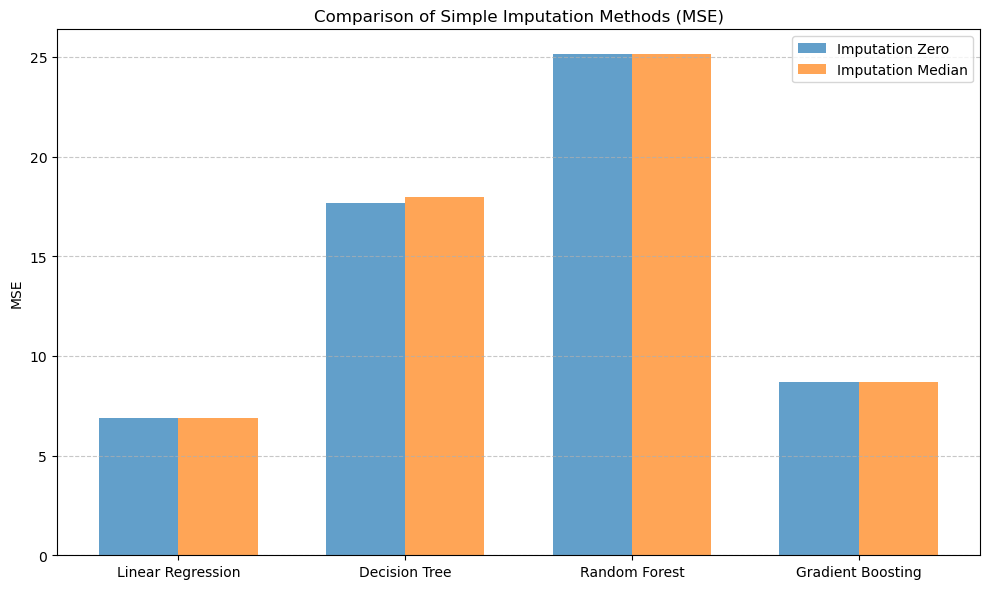

In [1]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputation Zero', 'Imputation Median']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [6.90, 17.69, 25.13, 8.71]
mse_median = [6.87, 17.97, 25.13, 8.68]
x = np.arange(len(models)) 
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputation Zero', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputation Median', alpha=0.7)
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

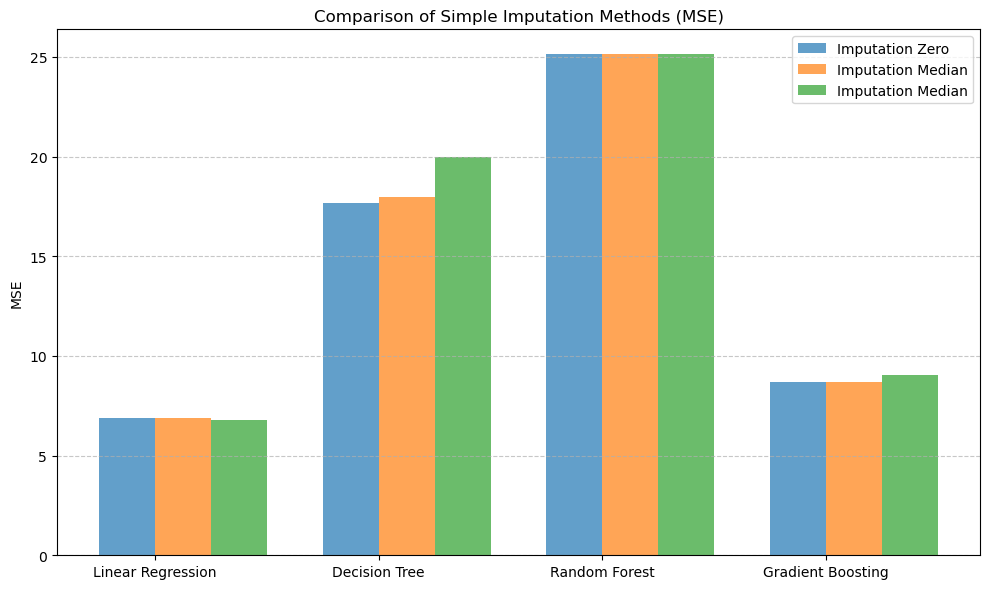

In [2]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputation Zero', 'Imputation Median']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [6.90, 17.69, 25.13, 8.71]
mse_median = [6.87, 17.97, 25.13, 8.68]
mse_mice = [6.79, 19.99, 25.13, 9.06]
x = np.arange(len(models)) 
width = 0.25  
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputation Zero', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputation Median', alpha=0.7)
plt.bar(x + width*1.5, mse_mice, width, label='Imputation Median', alpha=0.7)
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
data = {
    "method": [
        "zero", "zero", "zero", "zero",
        "mediana", "mediana", "mediana", "mediana",
        "MICE", "MICE", "MICE", "MICE",
        "KNN", "KNN", "KNN", "KNN",
        "LightGBM", "LightGBM", "LightGBM", "LightGBM"
    ],
    "model": [
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB"
    ],
    "R2": [
        0.97, 0.91, 0.88, 0.96,
        0.97, 0.91, 0.88, 0.96,
        0.97, 0.90, 0.88, 0.96,
        0.97, 0.91, 0.88, 0.96,
        0.96, 0.90, 0.88, 0.96
        
    ]
}

df = pd.DataFrame(data)
print(df)


      method model    R2
0       zero    LR  0.97
1       zero    DT  0.91
2       zero    RF  0.88
3       zero    GB  0.96
4    mediana    LR  0.97
5    mediana    DT  0.91
6    mediana    RF  0.88
7    mediana    GB  0.96
8       MICE    LR  0.97
9       MICE    DT  0.90
10      MICE    RF  0.88
11      MICE    GB  0.96
12       KNN    LR  0.97
13       KNN    DT  0.91
14       KNN    RF  0.88
15       KNN    GB  0.96
16  LightGBM    LR  0.96
17  LightGBM    DT  0.90
18  LightGBM    RF  0.88
19  LightGBM    GB  0.96


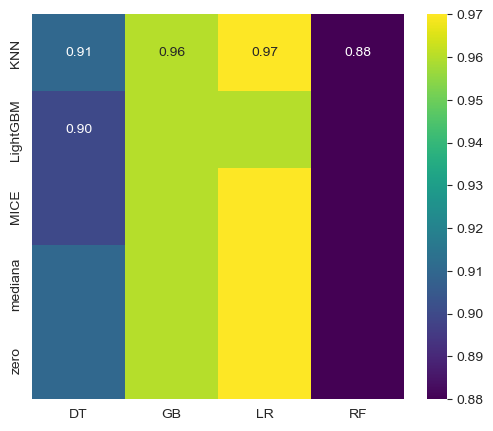

In [3]:
df_pivot_r2 = df.pivot(index="method", columns="model", values="R2")
plt.figure(figsize=(6, 5))
sns.heatmap(df_pivot_r2, annot=True, cmap="viridis", fmt=".2f")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.show()

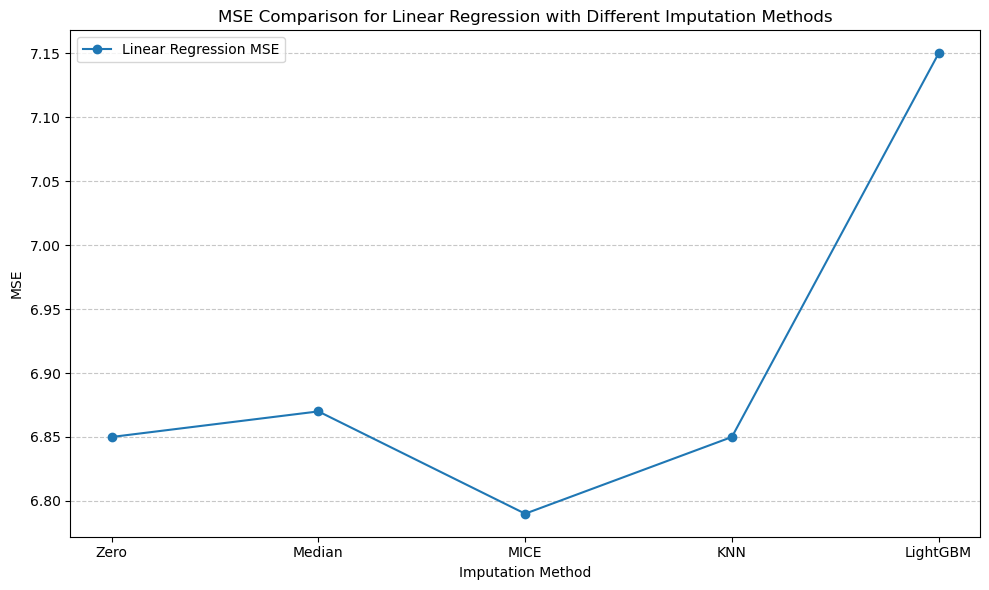

In [97]:
mse_methods = [6.85, 6.87, 6.79, 6.85, 7.15]
methods = ['Zero', 'Median', 'MICE', 'KNN', 'LightGBM']
plt.figure(figsize=(10, 6))
plt.plot(methods, mse_methods, marker='o', linestyle='-', label='Linear Regression MSE')
plt.ylabel('MSE')
plt.xlabel('Imputation Method')
plt.title('MSE Comparison for Linear Regression with Different Imputation Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()